# Cross cross resonance SWAP

# 1. Find the first CR pulse for CCR: 
### Isolate the maintained and calibrated Cross Resonance pulse from CX basis gate

- CR is implemented in standard CNOT gate: go and analyze those CNOT pulses to find and isolate CR!

- CR pulse is equivalent to Rxz(pi / 4)

- CR pulse = Driving control qubit with frequency of target qubit

- Maintained CR pulse only implemented for one direction for each qubit pair (backend uses a lot of extra pulses to rotate qubits back and forth before and after CR, when CNOT is used in the not implemented direction) -> maby two extra lines of code here to switch directions of standard SWAP instead of actually rotating qubits?


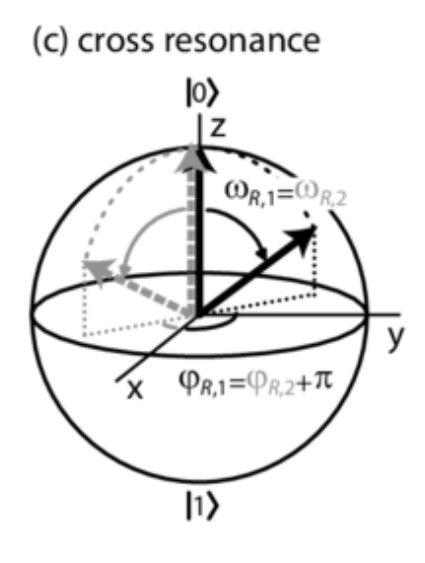


### CR Analysis

In [1]:
# just some standard import...
from qiskit import pulse
import os, json
import numpy as np
import matplotlib.pyplot as plt
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform
from qiskit.pulse.library import drag, GaussianSquare
from qiskit.visualization import SchedStyle
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.test.mock import FakeAthens

# account + backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

# plot more beautiful
style = SchedStyle(figsize=(20, 10))
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 15]


C:\ProgramData\Anaconda3\envs\walter\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Sampling time: 0.2222222222222222 ns


['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
								  'x' and 'measure' are pulses for echoes

								  'u1' ,'u2' and 'u3' are single qubit gates

pulse for measure:


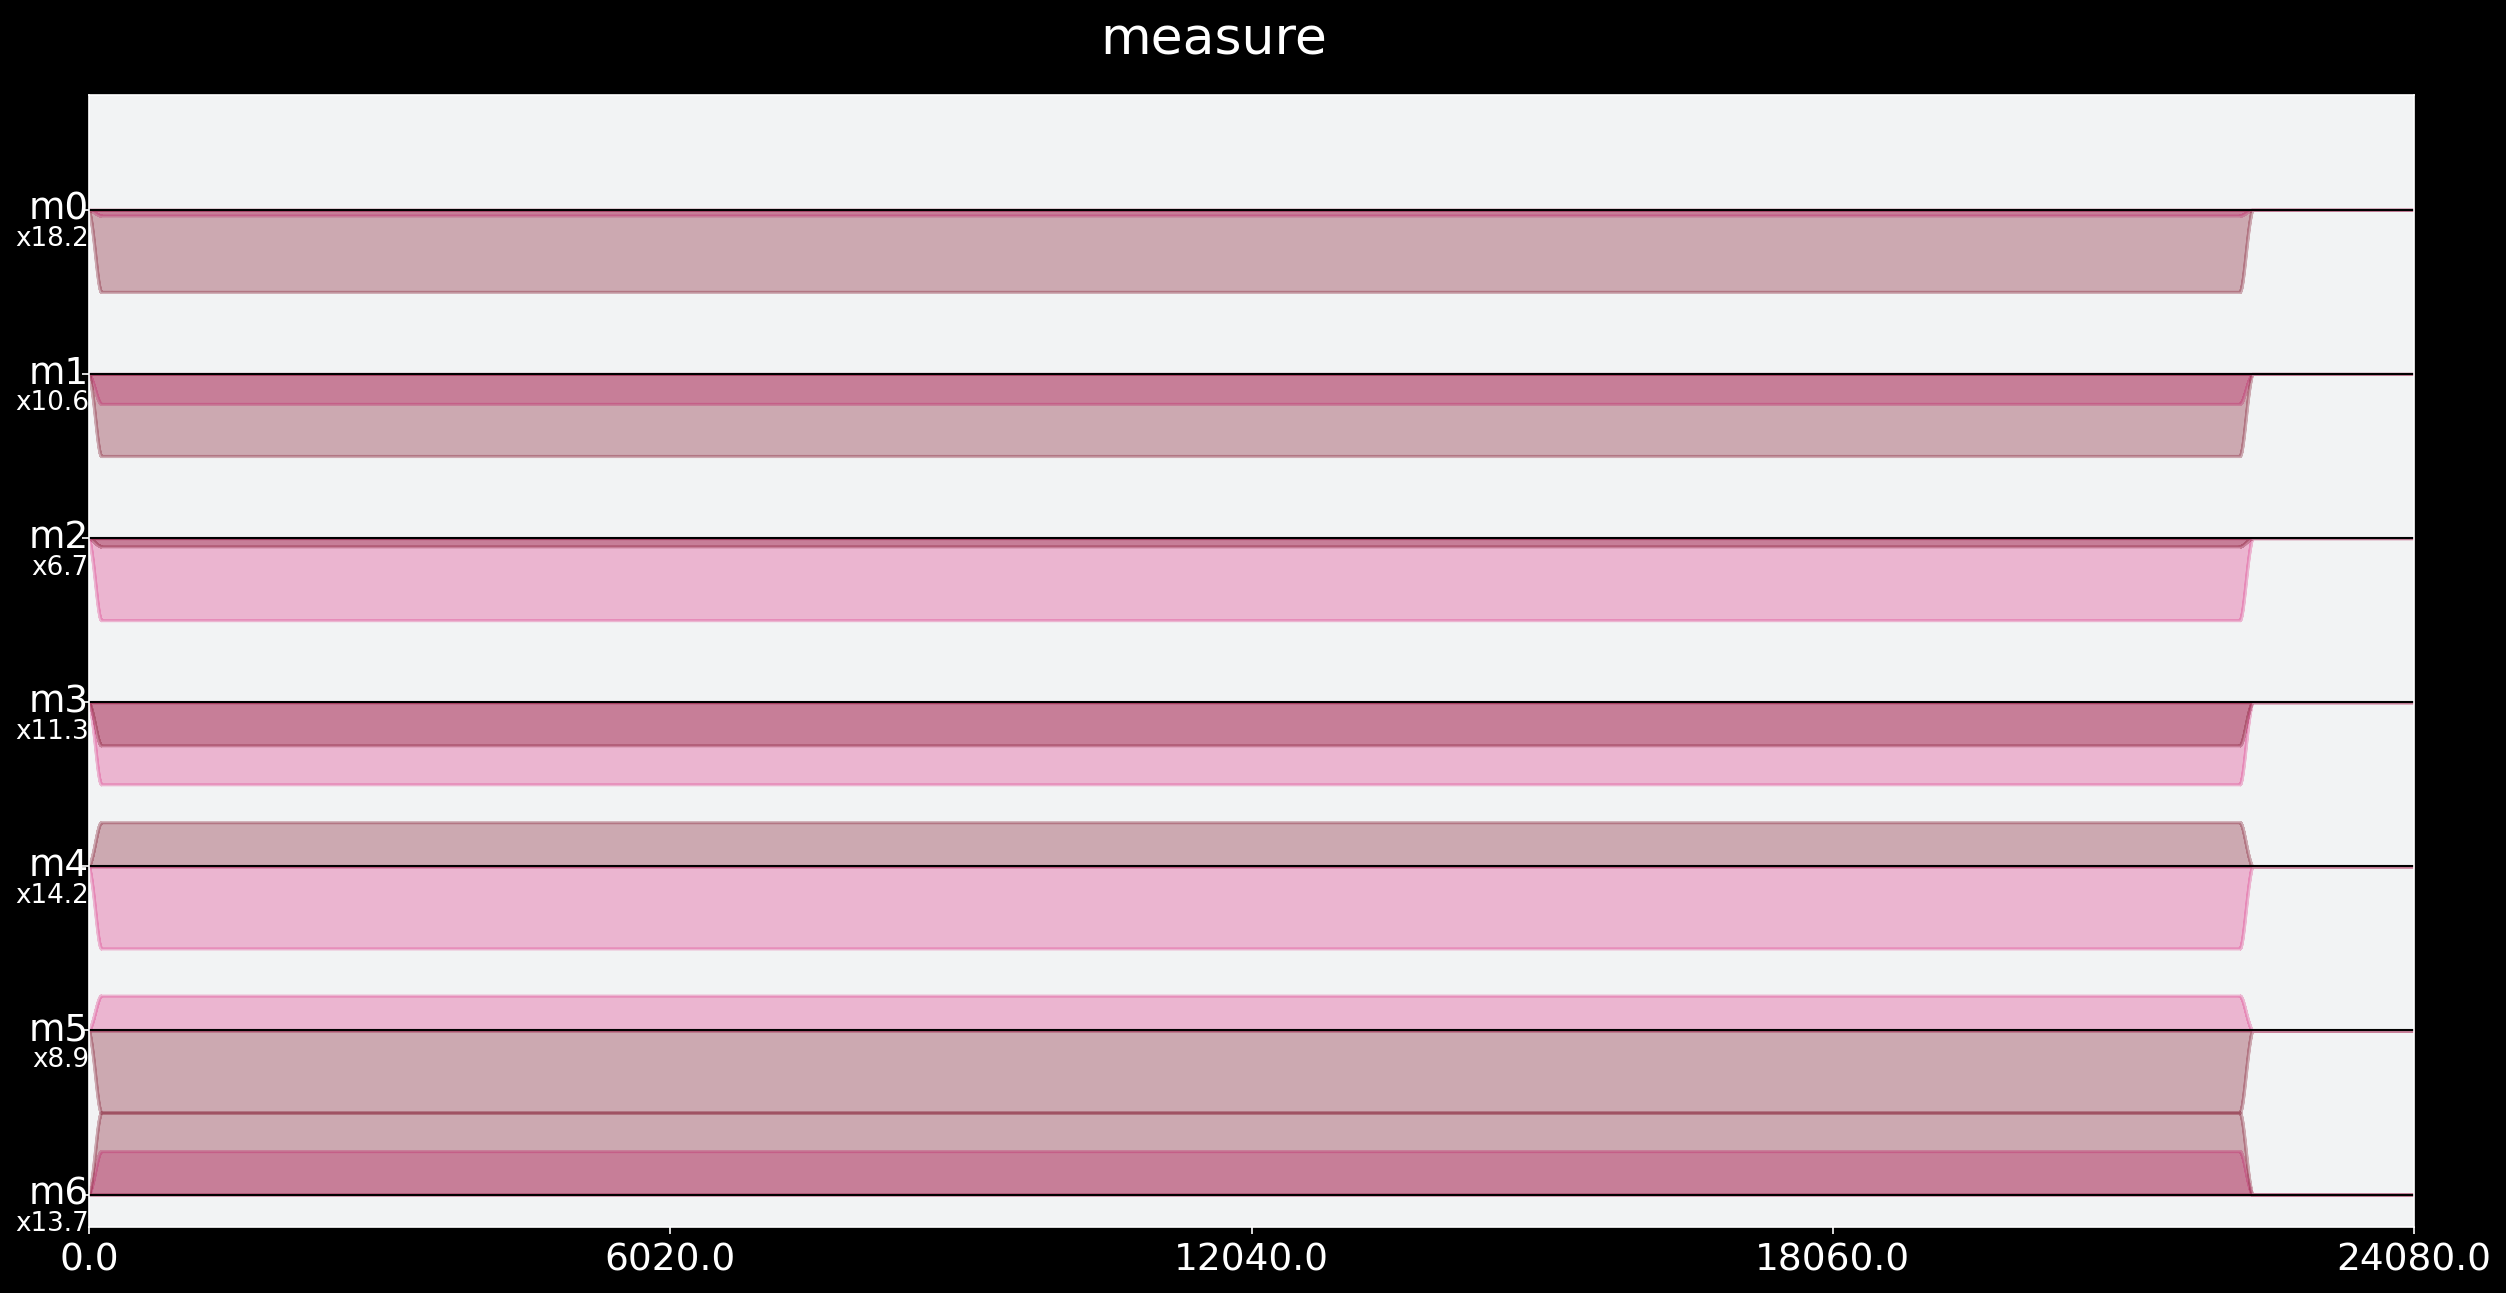

In [2]:
# collect backend configurations and defaults

backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt=backend_config.dt  # hardware resolution
backend.configuration().parametric_pulses = [] # will allow us to send a larger waveform for our experiments
inst_sched_map = backend_defaults.instruction_schedule_map 
ham_params = backend_config.hamiltonian['vars']

print(f"Sampling time: {dt*1e9} ns\n\n") 
print(inst_sched_map.instructions)
print("\t"*8," 'x' and 'measure' are pulses for echoes\n")
print("\t"*8," 'u1' ,'u2' and 'u3' are single qubit gates\n")

# identify measurement pulse + channel for qubits (can be used for echos, eventually must be removed from default calibrations)
meas = inst_sched_map.get('measure', qubits=range(backend_config.n_qubits))
print('pulse for measure:')
meas.exclude(channels=[pulse.AcquireChannel(i) for i in range(backend_config.n_qubits)]).draw(style=style)

In [3]:
# funcs to fish the CR instructions from backend defaults 

def cx_pulse_instructions(qc: int, qt: int) -> Schedule:
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx
    
def get_cr_chan_inst(qc: int, qt: int) -> (ControlChannel, Waveform):
    cx = cx_pulse_instructions(qc, qt)
    idx = 0
    # look for first Play instruction on a ControlChannel
    while (type(cx.instructions[idx][1].channels[0]) is not ControlChannel) or \
        (type(cx.instructions[idx][1]) is not Play):
        idx += 1
    return (cx.instructions[idx][1].channels[0], cx.instructions[idx][1].pulse)

In [4]:
# CR instructions fished from backend defauts:

uchan_c1t3, cr_pulse_c1t3 = get_cr_chan_inst(1, 3)
params_CRpulse_c1t3 = cr_pulse_c1t3.parameters
CX_c1t3_intrusctions = cx_pulse_instructions(1, 3)
print("\ncr_pulse_c1t3: \n\t\t\t",cr_pulse_c1t3,"\nuchan_c1t3: \n\t\t\t", uchan_c1t3)
print("CR pulse parameters: \n\t\t\t", params_CRpulse_c1t3)

uchan_c3t1, cr_pulse_c3t1 = get_cr_chan_inst(3, 1)
params_CRpulse_c3t13 = cr_pulse_c3t1.parameters
CX_c3t1_intrusctions = cx_pulse_instructions(3, 1)
print("\n\ncr_pulse_c3t1: \n\t\t\t",cr_pulse_c3t1,"\nuchan_c3t1: \n\t\t\t",uchan_c3t1)
print("CR pulse parameters: \n\t\t\t", params_CRpulse_c3t13)

if [uchan_c1t3 == uchan_c3t1, cr_pulse_c1t3 == cr_pulse_c3t1, params_CRpulse_c1t3 == params_CRpulse_c3t13] == [True,True,True]:
    print("\n\nCR pulse, Channel and Parameters are the same for control 3 + target 1 and control 1 + target 3\n\n")
        
print('\n\nCX instructions for control 3 target 1: \n\t\t\t\t\t', CX_c3t1_intrusctions)
print('\n\nCX instructions for control 1 target 3: \n\t\t\t\t\t', CX_c1t3_intrusctions)


cr_pulse_c1t3: 
			 GaussianSquare(duration=560, amp=(-0.3262063007419686-0.1634033587274177j), sigma=64, width=304) 
uchan_c1t3: 
			 ControlChannel(5)
CR pulse parameters: 
			 {'duration': 560, 'amp': (-0.3262063007419686-0.1634033587274177j), 'sigma': 64, 'width': 304}


cr_pulse_c3t1: 
			 GaussianSquare(duration=560, amp=(-0.3262063007419686-0.1634033587274177j), sigma=64, width=304) 
uchan_c3t1: 
			 ControlChannel(5)
CR pulse parameters: 
			 {'duration': 560, 'amp': (-0.3262063007419686-0.1634033587274177j), 'sigma': 64, 'width': 304}


CR pulse, Channel and Parameters are the same for control 3 + target 1 and control 1 + target 3




CX instructions for control 3 target 1: 
					 Schedule((0, ShiftPhase(1.5707963267948966, DriveChannel(3))), (0, ShiftPhase(1.5707963267948966, ControlChannel(3))), (0, ShiftPhase(1.5707963267948966, ControlChannel(8))), (0, Play(Drag(duration=160, amp=(0.09088794201100041+0.0015595319821180014j), sigma=40, beta=-0.5674364342099053), DriveChann

In [5]:
CX_c3t1_intrusctions.timeslots

{DriveChannel(1): [(0, 160), (160, 720), (880, 1440)],
 DriveChannel(3): [(0, 0), (0, 160), (720, 880)],
 ControlChannel(3): [(0, 0)],
 ControlChannel(5): [(160, 720), (880, 1440)],
 ControlChannel(8): [(0, 0)]}

In [6]:
CX_c1t3_intrusctions.timeslots

{DriveChannel(1): [(0, 0),
  (0, 160),
  (160, 720),
  (880, 1440),
  (1440, 1440),
  (1440, 1600)],
 DriveChannel(3): [(0, 0), (0, 160), (720, 880), (1440, 1600)],
 ControlChannel(0): [(0, 0), (1440, 1440)],
 ControlChannel(3): [(0, 0)],
 ControlChannel(4): [(0, 0), (1440, 1440)],
 ControlChannel(5): [(0, 0), (160, 720), (880, 1440), (1440, 1440)],
 ControlChannel(8): [(0, 0)]}

In [7]:
print(cr_pulse_c3t1) # drive control 3 in frequency of target 1
print(cr_pulse_c1t3) # drive control 1 in frequency of target 3

# verify default CR pulses are actually only one pulse:
cr_pulse_c1t3 == cr_pulse_c3t1

GaussianSquare(duration=560, amp=(-0.3262063007419686-0.1634033587274177j), sigma=64, width=304)
GaussianSquare(duration=560, amp=(-0.3262063007419686-0.1634033587274177j), sigma=64, width=304)


True

### Note: Implemented CR goes in direction control 3 -> target 1

- If control is defined as 1 and target as 3 there are a lot of extra rotation before and after CR pulse
-   ==   Implemented CR drives control 3 with frequency of target 1

In [8]:
# This is the first CR pulse for CCR pulse:

print(cr_pulse_c3t1) # drive control 3 in frequency of target 1

GaussianSquare(duration=560, amp=(-0.3262063007419686-0.1634033587274177j), sigma=64, width=304)


# 2. Reconstruct first Cross Resonance pulse

- For the basis gate CX the CR pulse is only implemented in one direction. Reconstruct the Calibrated CR pulse to verify the procedure of pulse construction to match calibrations by IBM
- Use procedure of this CR pulse contruction to build a second CR pulse in opposite direction

In [9]:
def build_cr_pulse(qc: int, qt: int, width: int, control='0', basis='Z', phase=0.0, framechange=0.0) -> Schedule:
    with pulse.build() as sched:
        with pulse.align_sequential():
            if control == '1':
                Xp = inst_sched_map.get('x', qubits=[qc])
                pulse.call(Xp) # flip control from |0> to |1>
            duration = width + 2*cr_risefall
            uchan, _ = get_cr_chan_inst(qc,qt)
            with pulse.phase_offset(phase, uchan):
                pulse.play(GaussianSquare(duration=duration, amp=cr_amp, sigma=cr_risefall//2, width=width), uchan)
            pulse.shift_phase(framechange, DriveChannel(qc))
            if basis == 'X': # rotate target for appropriate Pauli measurement
                Y90m = inst_sched_map.get('u2', P0=np.pi, P1=np.pi, qubits=[qt])
                pulse.call(Y90m)
            elif basis == 'Y':
                X90p = inst_sched_map.get('u2', P0=-np.pi/2, P1=np.pi/2, qubits=[qt])
                pulse.call(X90p) 
            return sched

def build_cr_scheds(qc: int, qt: int, cr_times, phase=0.0, ZI_MHz=0.0) -> np.array:
    scheds = []
    for width in cr_times:
        framechange = 2*np.pi*int(width)*dt*ZI_MHz*1e6
        for basis in ['X', 'Y', 'Z']:
            for control in ['0', '1']:
                with pulse.build(name="CR width %i" %width) as sched:
                    with pulse.align_sequential():
                        pulse.call(build_cr_pulse(qc, qt, int(width), control=control, \
                                                  basis=basis, phase=phase, framechange=framechange))
                        pulse.call(meas)
                scheds.append(sched)
    return scheds

from scipy.optimize import leastsq,minimize, curve_fit

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# Gaussian function
def gaussian(f, f0, sigma, a, offs):
    return a*np.exp(-(f-f0)**2/(2*sigma**2))+offs

#fit_gaussian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the gaussian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_gaussian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(gaussian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# normalize the data points to fall in the range of [0,1]
def normalize(a):
    a= a-min(a)
    return a/max(a)

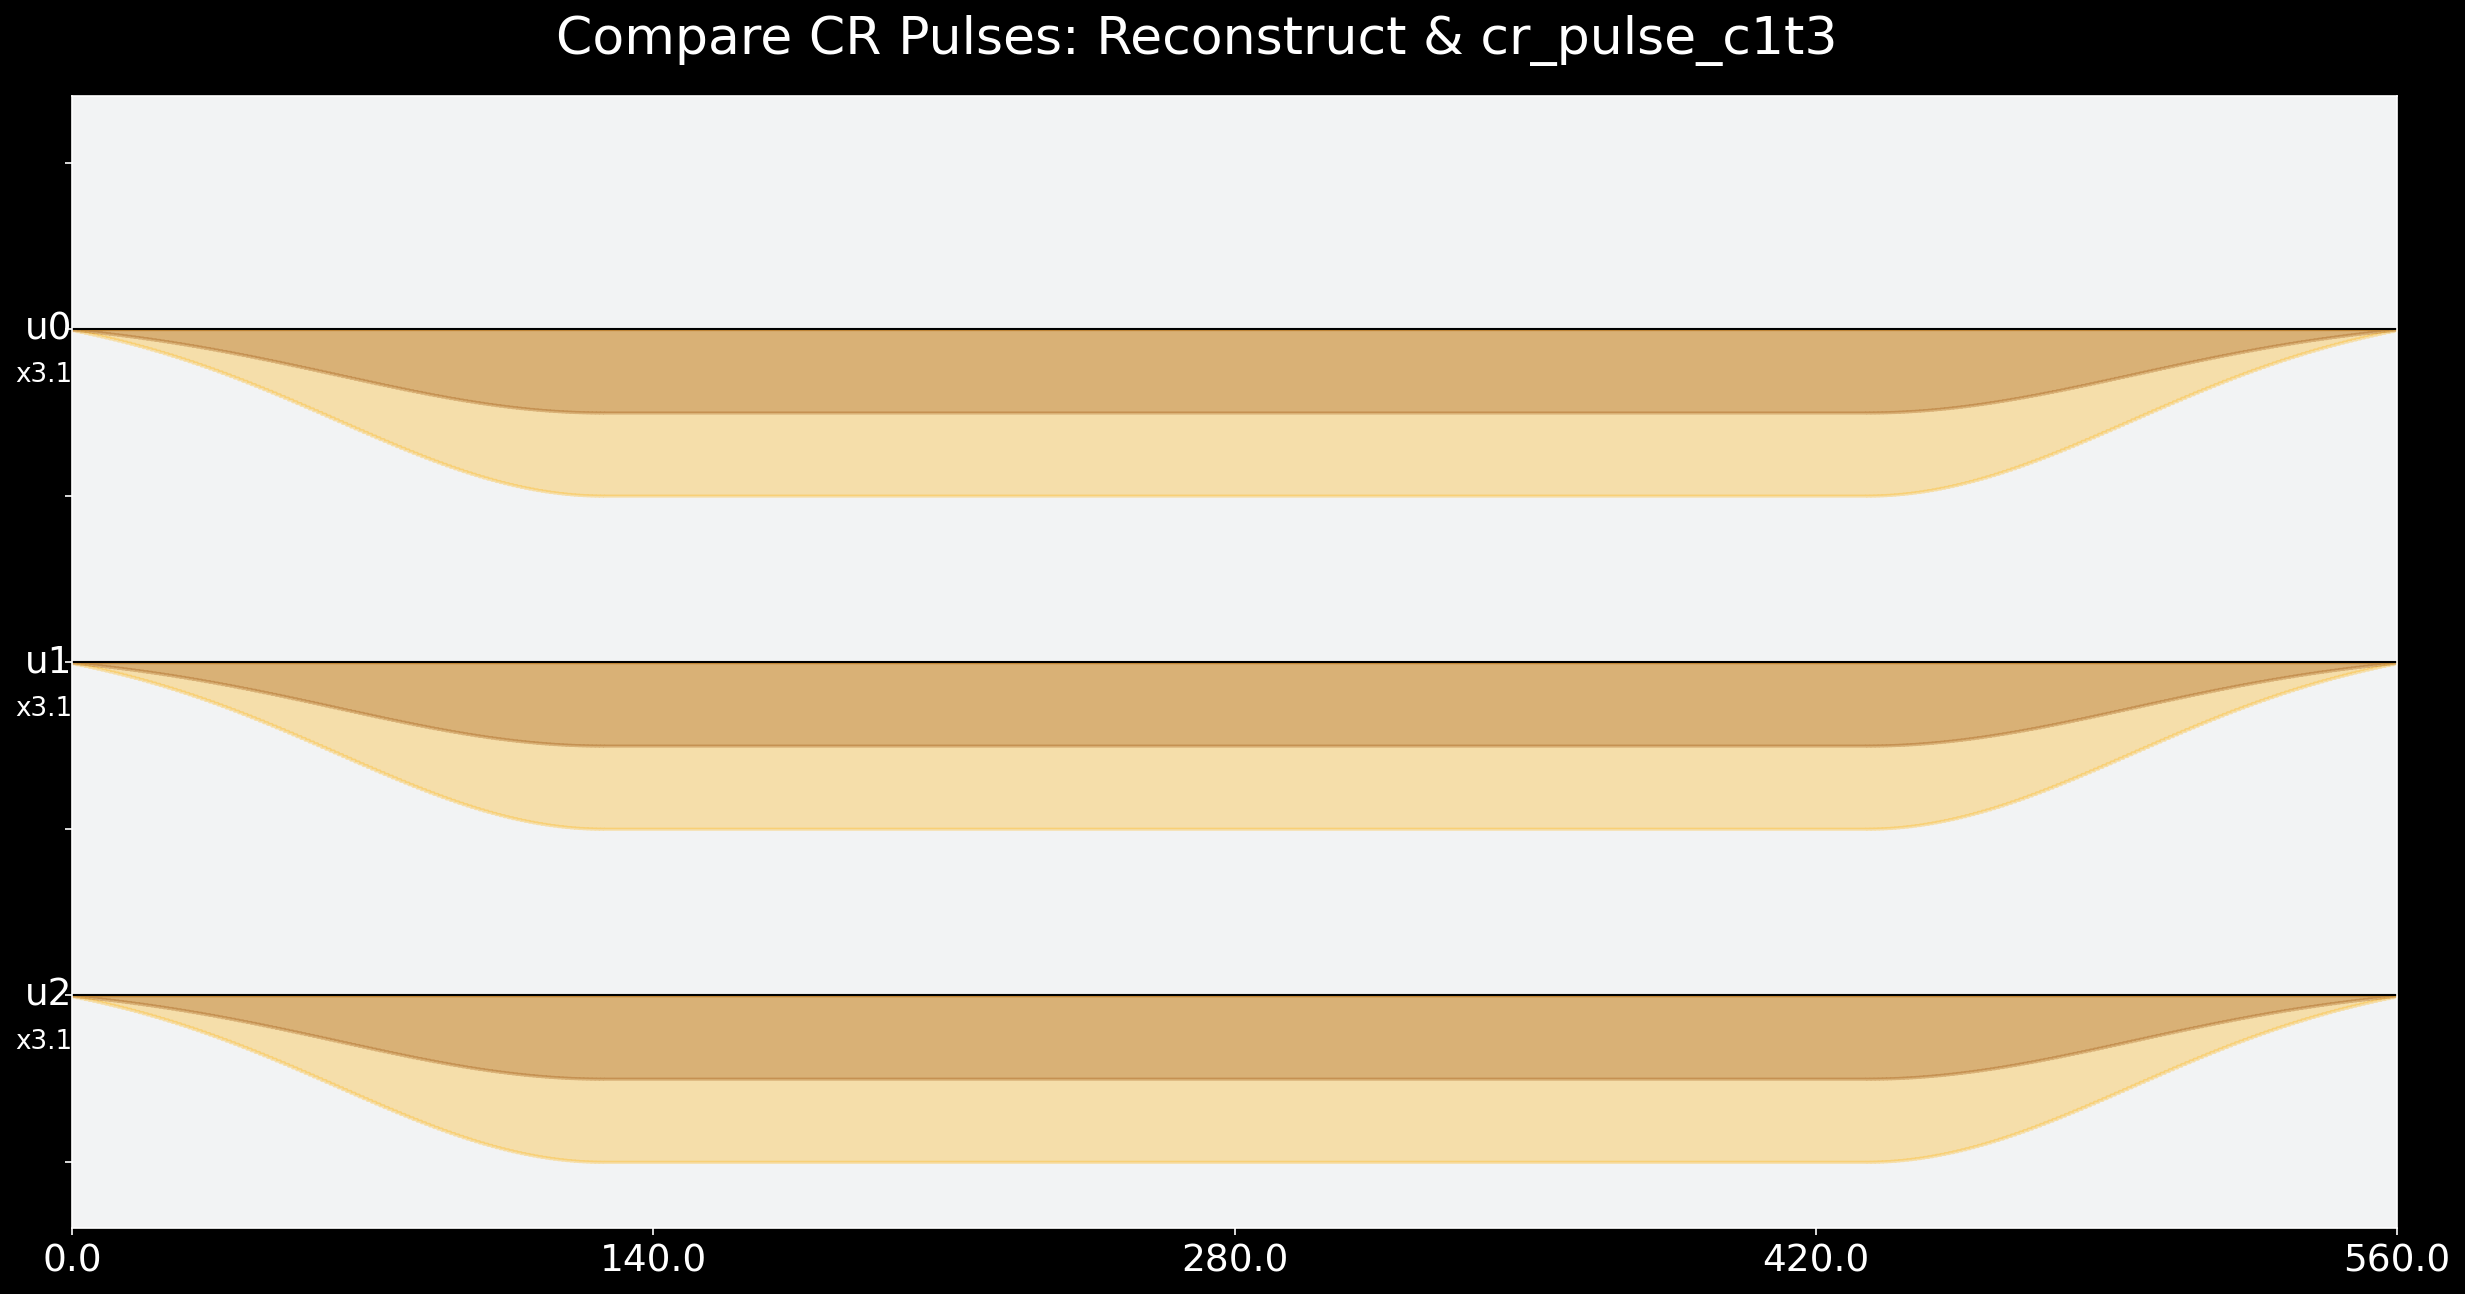

In [10]:
cr_risefall = 128 # guess

cr_amp_c1t3 = cr_pulse_c1t3.amp
cr_dur_c1t3 = cr_pulse_c1t3.duration
cr_width_c1t3 = cr_dur_c1t3 - 2*cr_risefall

cr_amp_c3t1 = cr_pulse_c3t1.amp
cr_dur_c3t1 = cr_pulse_c3t1.duration
cr_width_c3t1 = cr_dur_c3t1 - 2*cr_risefall

reconstructed_CR_pulse = GaussianSquare(duration=cr_dur_c1t3, amp=cr_amp_c1t3, sigma=cr_risefall//2, width=cr_width_c1t3)
reconstructed_CR_pulse.draw()

with pulse.build(name="Compare CR Pulses: Reconstruct & cr_pulse_c1t3") as cr_test_sched:
    pulse.play(cr_pulse_c1t3, ControlChannel(0))
    pulse.play(cr_pulse_c3t1, ControlChannel(1))
    pulse.play(reconstructed_CR_pulse, ControlChannel(2))

cr_test_sched.draw(style=style)

In [11]:
drive_chan_Q3 = pulse.DriveChannel(3)   # drive channel
meas_chan_Q3 = pulse.MeasureChannel(3)  # resonator channel
acq_chan_Q3 = pulse.AcquireChannel(3)   # readout signal acquisition channel

drive_chan_Q1 = pulse.DriveChannel(1)   # drive channel
meas_chan_Q1 = pulse.MeasureChannel(1)  # resonator channel
acq_chan_Q1 = pulse.AcquireChannel(1)   # readout signal acquisition channel

default_duration=560
default_amp = (-0.32609606664029767-0.1591967745569052j)
default_sigma=64
default_width=304

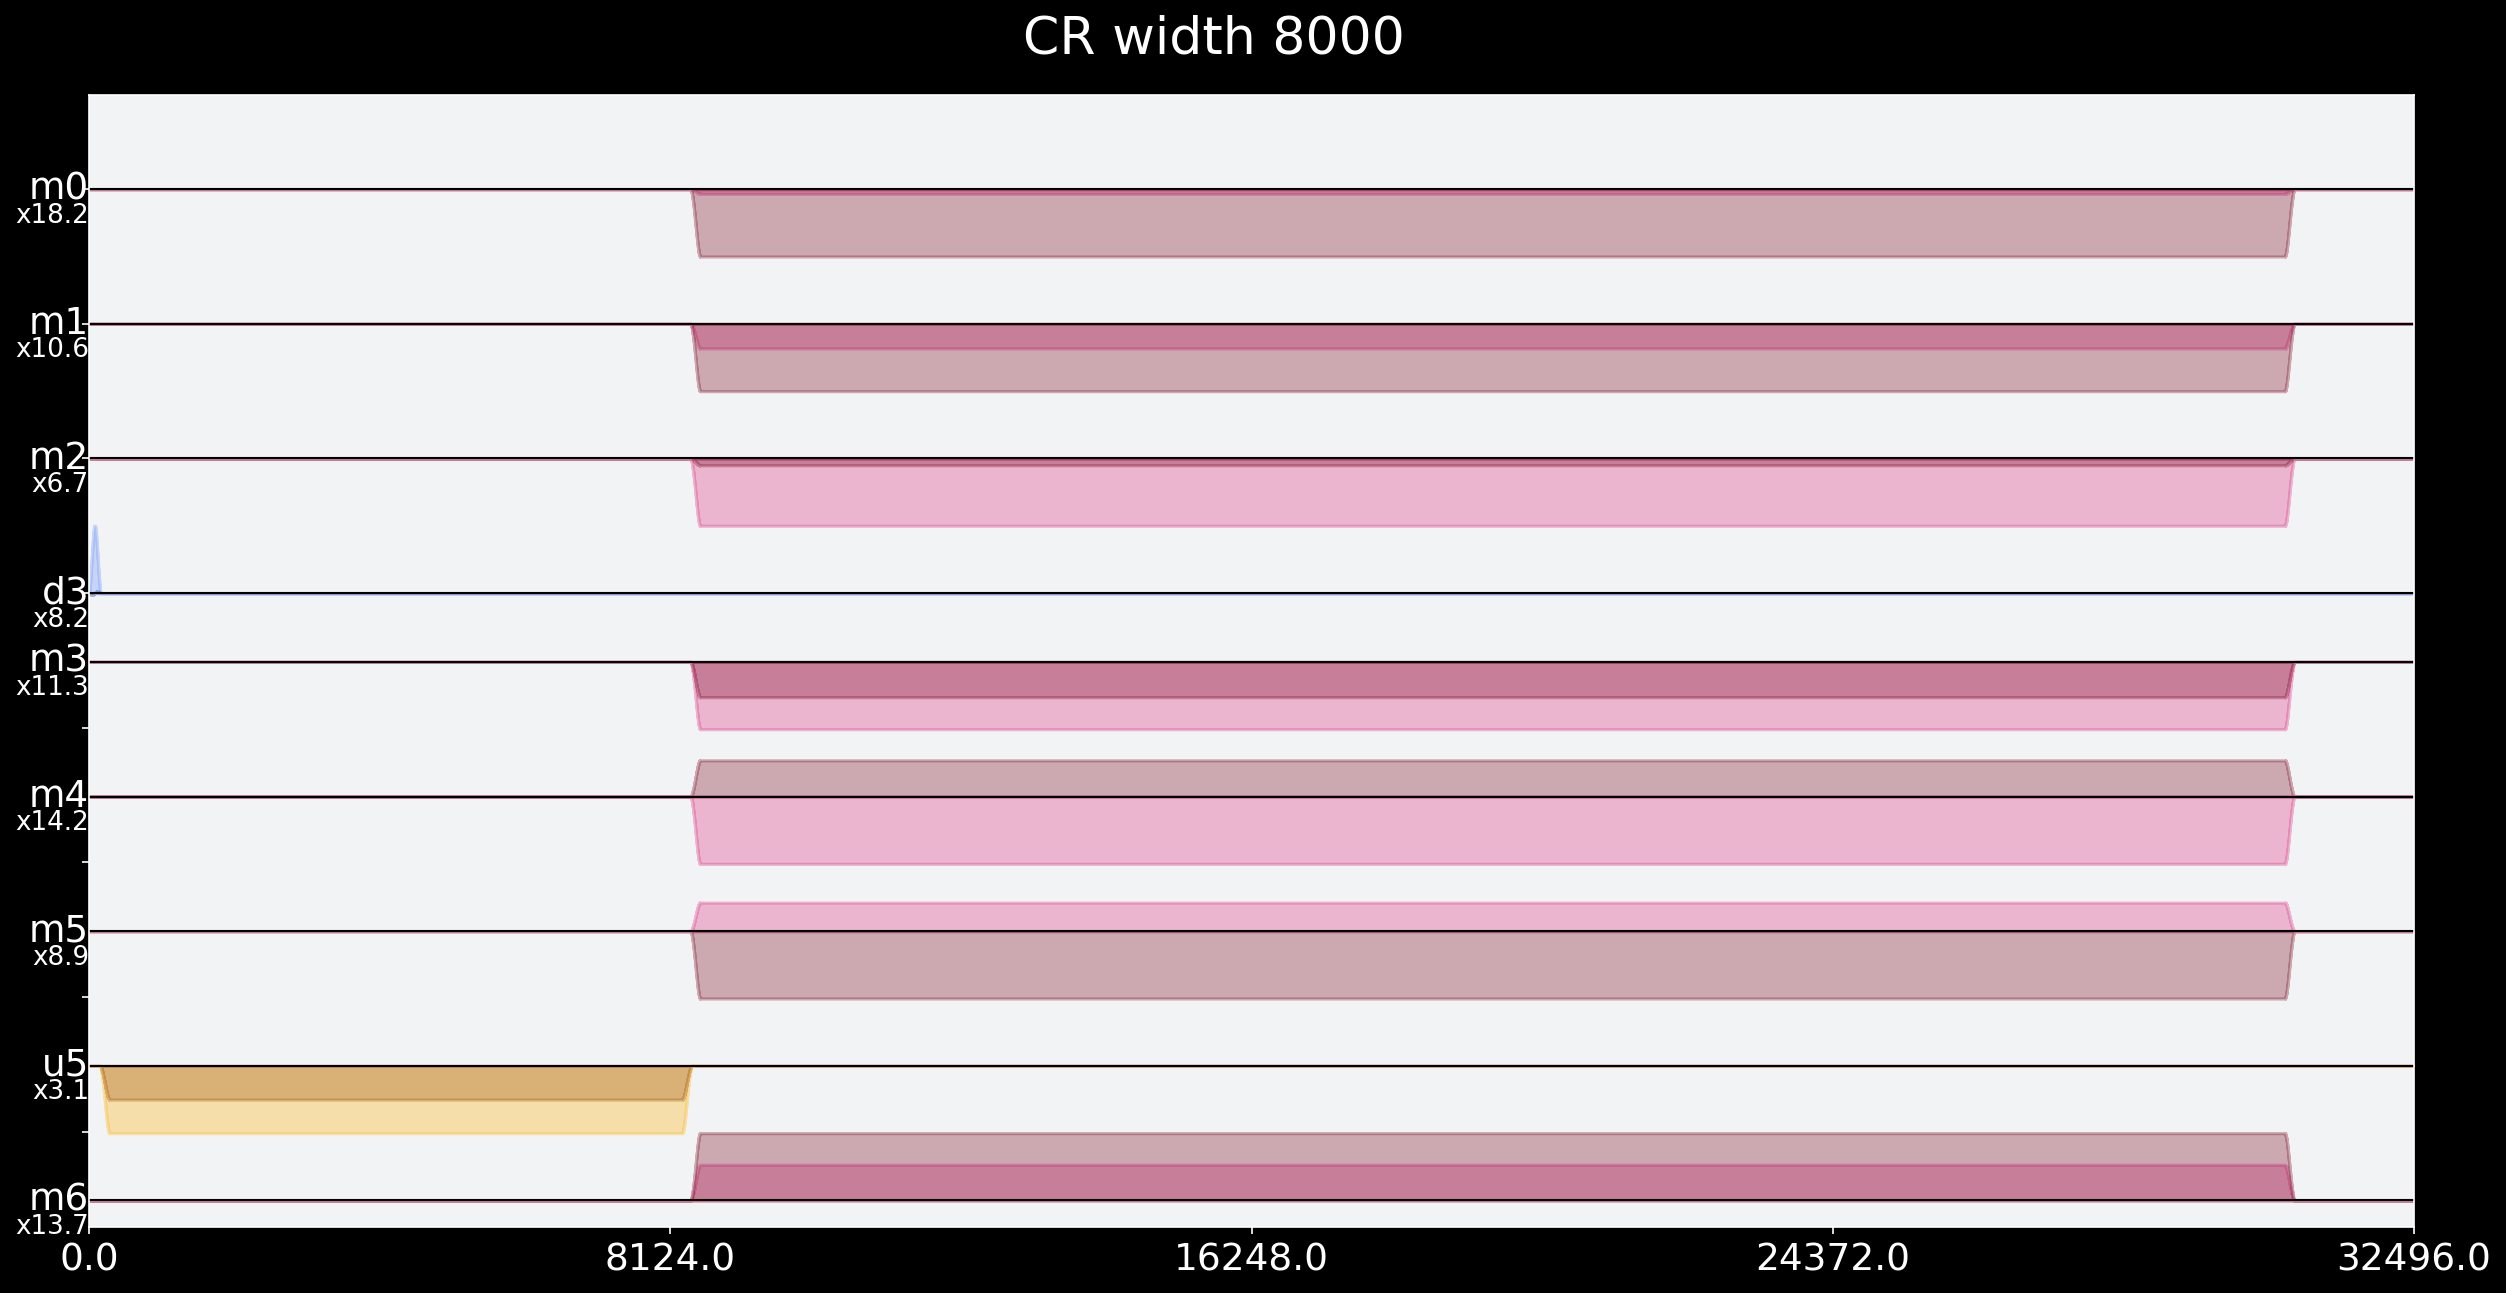

In [12]:
cr_amp = cr_pulse_c3t1.amp
qc, qt = 3,1
cr_times = 16*np.linspace(0, 500, 21)
cr_scheds = build_cr_scheds(qc, qt, cr_times)
cr_scheds[-1].exclude(channels=[pulse.AcquireChannel(i) for i in range(backend_config.n_qubits)]).draw(style=style)

#### First CR pulse for CCR found! It is the default CR for control 3 -> target, calibrated for frequency of target (Q1_GHz) and maintained by IBM

## 3. Buildind the second Cross Resonance pulse for CCR

CCR pulse drives both qubits in the frequency of each other:

- Use reconstruction of CR pulse to make a second CR pulse going in the direction control 1 -> target 3
- Use backend defaults to search for a qubit pair with default CX going from qubit 1 to another one
- If backend provides matching CR pulse, use that to construct second part of CCR pulse. If not, build it from calibrations in Notebook Folder "CR_CZ_Experiments"

In [13]:
print(backend_defaults)

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'x', 'u1', 'id', 'rz', 'measure', 'sx', 'u2', 'u3'}
  q1: {'x', 'u1', 'id', 'rz', 'measure', 'sx', 'u2', 'u3'}
  q2: {'x', 'u1', 'id', 'rz', 'measure', 'sx', 'u2', 'u3'}
  q3: {'x', 'u1', 'id', 'rz', 'measure', 'sx', 'u2', 'u3'}
  q4: {'x', 'u1', 'id', 'rz', 'measure', 'sx', 'u2', 'u3'}
  q5: {'x', 'u1', 'id', 'rz', 'measure', 'sx', 'u2', 'u3'}
  q6: {'x', 'u1', 'id', 'rz', 'measure', 'sx', 'u2', 'u3'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 5): {'cx'}
  (4, 5): {'cx'}
  (5, 3): {'cx'}
  (5, 4): {'cx'}
  (5, 6): {'cx'}
  (6, 5): {'cx'}
  (0, 1, 2, 3, 4, 5, 6): {'measure'}
)>Qubit Frequencies [GHz]
[4.822053884776412, 4.75984794299699, 4.907313036251738, 4.878965103735976, 4.870897935582809, 4.963900372144626, 5.177100071192823]
Measurement Frequencies [GHz]
[7.284054663, 7.385438514, 7.32318003, 7.230756417, 7.280310863, 7.14699337

In [14]:
# calibrated qubit frequencies from backend:
GHz_Qubit_default = [4.822060197521334, 4.759820204469057, 4.907307270165438, 4.8789602684859785, 
                     4.870898459748081, 4.963898651967502, 5.177100088457835]

# frequencies of q1 and q3:
Q1_GHz, Q3_GHz = GHz_Qubit_default[1], GHz_Qubit_default[3]

print(Q1_GHz, Q3_GHz)

4.759820204469057 4.8789602684859785


In [15]:
# look for qubit 1 + other qubit CX instructions

control_1 = 1
other_qubits = [0,2,4,5,6]
partners_for_control1 = []

for oq in other_qubits:
    inst_control1 = cx_pulse_instructions(control_1,oq)
    inst_target1 = cx_pulse_instructions(oq,control_1)
    print("\ncontrol_1, target",oq)
    print(inst_control1)
    print(oq, "control, target 1")
    print(inst_target1)


control_1, target 0
Schedule((0, ShiftPhase(1.5707963267948966, DriveChannel(1))), (0, ShiftPhase(1.5707963267948966, ControlChannel(0))), (0, ShiftPhase(1.5707963267948966, ControlChannel(4))), (0, ShiftPhase(1.5707963267948966, ControlChannel(5))), (0, Play(Drag(duration=160, amp=(0.06609226827109388+0.000912373667100603j), sigma=40, beta=-0.2491118115104453), DriveChannel(0))), (0, Play(Drag(duration=160, amp=(-3.3403554768156836e-17-0.18184048272211326j), sigma=40, beta=-0.6320135312613582), DriveChannel(1))), (160, Play(GaussianSquare(duration=880, amp=(0.023928400085393722+0.0005922800775212528j), sigma=64, width=624), DriveChannel(0))), (160, Play(GaussianSquare(duration=880, amp=(0.09465381956379383+0.20045650097293158j), sigma=64, width=624), ControlChannel(1))), (1040, Play(Drag(duration=160, amp=(0.18184048272211326+0j), sigma=40, beta=-0.6320135312613582), DriveChannel(1))), (1200, Play(GaussianSquare(duration=880, amp=(-0.023928400085393722-0.0005922800775212499j), sigma=

In [16]:
# potential partners found: q0 and q2

In [22]:
# look if potential partner is a match for qubit 1 

other_qubits = [0,2]
matching_partners_for_control_1 = []

for oq in other_qubits:
    uchan, cr_pulse = get_cr_chan_inst(1, oq)
    inst_control1 = cx_pulse_instructions(control_1,oq)
    inst_target1 = cx_pulse_instructions(oq,control_1)
    if len(inst_control1) > len(inst_target1):
        matching_partners_for_control_1.append((control_1,oq))
    else:
        print("1 as control len:",len(inst_control1), oq ,"as control len:",len(inst_target1))
print("matching_partners_for_control_1:",matching_partners_for_control_1)

1 as control len: 11 0 as control len: 17
1 as control len: 11 2 as control len: 17
matching_partners_for_control_1: []


In [23]:
# no matching partners!